In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']
DATA_PATH = os.path.join(LOCAL_PATH, "intermediate_data/cpc")

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt
import writing_tools as wt

from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

rng = np.random.default_rng(12898)

RESULTS = {}

MANIFEST = pd.read_csv(os.path.join(DATA_PATH, 'meetings-manifest.csv'))


In [2]:
df = dt.get_analysis_data()
dfa = dt.get_agenda_items(verbose=False)
dfl = dt.get_supplemental_docs(verbose=False)

In [3]:
# Basic info

NUMBER_OF_MEETINGS = df['date'].nunique()
FIRST_MEETING_DATE = pd.to_datetime(df['date']).min()
LAST_MEETING_DATE = pd.to_datetime(df['date']).max()
NUMBER_OF_YEARS = LAST_MEETING_DATE.year - FIRST_MEETING_DATE.year + 1
NUMBER_OF_CASES = len(df)

RESULTS['NumberOfMeetings'] = f"{NUMBER_OF_MEETINGS}"
RESULTS['FirstMeetingDate'] = FIRST_MEETING_DATE.strftime('%Y-%m-%d')
RESULTS['LastMeetingDate'] = LAST_MEETING_DATE.strftime('%Y-%m-%d')
RESULTS['NumberOfYears'] = f"{NUMBER_OF_YEARS}"
RESULTS['NumberOfCases'] = f"{NUMBER_OF_CASES:,.0f}"

In [4]:
# Number of agenda items (total, including non-cases)

AGENDA_ITEMS = 0
for date in df['date'].unique():
    filename = os.path.join(DATA_PATH, date[0:4], date, 'agenda-items.pkl')
    mydf = pd.read_pickle(filename)
    AGENDA_ITEMS += len(mydf)

RESULTS['NumberOfAgendaItems'] = f"{AGENDA_ITEMS:,.0f}"

In [5]:
# Number of supplemental documents

SUPPLEMENTAL_DOCS = 0
for date in df['date'].unique():
    filename = os.path.join(DATA_PATH, date[0:4], date, 'supplemental-docs.pkl')
    mydf = pd.read_pickle(filename)
    SUPPLEMENTAL_DOCS += len(mydf)

RESULTS['NumberOfSupplementalDocs'] = f"{SUPPLEMENTAL_DOCS:,.0f}"

In [6]:
# Page counts

PAGE_COUNT = 0
for date in df['date'].unique():
    row = MANIFEST.loc[MANIFEST['date'] == date].iloc[0]
    PAGE_COUNT += row['agenda_pages'] + row['minutes_pages'] + row['supdocs_pages']

RESULTS['PageCount'] = f"{PAGE_COUNT:,.0f}"
    

In [7]:
# Motion results vs. unanimity

df['unanimity'] = ''
df.loc[ df['n_nays']==0, 'unanimity'] = 'Unanimous'
df.loc[ df['n_nays']==1, 'unanimity'] = '1 Nay'
df.loc[ df['n_nays']>1, 'unanimity'] = '>1 Nays'

summ_tbl = pd.crosstab(df['project_result'], df['unanimity'])

CasesDeniedPct = f"{(summ_tbl.iloc[3].sum() / summ_tbl.sum().sum()) * 100:.0f}\\%"
CasesContinuedPct = f"{(summ_tbl.iloc[2].sum() / summ_tbl.sum().sum()) * 100:.0f}\\%"
CasesApprovedWithModsPct = f"{(summ_tbl.iloc[1].sum() / summ_tbl.sum().sum()) * 100:.0f}\\%"
CasesUnanimousPct = f"{(summ_tbl.loc[:, 'Unanimous'].sum() / summ_tbl.sum().sum()) * 100:.0f}\\%"

RESULTS['CasesDeniedPct'] = CasesDeniedPct
RESULTS['CasesContinuedPct'] = CasesContinuedPct
RESULTS['CasesApprovedWithModsPct'] = CasesApprovedWithModsPct
RESULTS['CasesUnanimousPct'] = CasesUnanimousPct

HEADER = """\\begin{tabular}{lrrrrr} \\toprule
 & \\multicolumn{3}{c}{Unanimity} &  & \\\\ 
Project Implication & Unanimous & 1 Nay & >1 Nays & Total &  \\\\ \\midrule"""
FOOTER = """\\bottomrule
\\end{tabular}"""
tbl = []
for idx, row in summ_tbl.iterrows():
    unanimous = f"{row['Unanimous']:,.0f}"
    one_nay = f"{row['1 Nay']:,.0f}"
    multiple_nays = f"{row['>1 Nays']:,.0f}"
    rowsum = f"{row.sum():,.0f}"
    pct = f"({row.sum()/summ_tbl.sum().sum()*100:.1f}\\%)"
    tbl.append([f"~ ~ {idx}", unanimous, one_nay, multiple_nays, rowsum, pct])
unanimous = f"{summ_tbl['Unanimous'].sum():,.0f}"
one_nay = f"{summ_tbl['1 Nay'].sum():,.0f}"
multiple_nays = f"{summ_tbl['>1 Nays'].sum():,.0f}"
total = f"{summ_tbl.sum().sum():,.0f}"
tbl.append([f"~ ~ TOTAL", unanimous, one_nay, multiple_nays, total, ""])
unanimous_pct = f"({summ_tbl['Unanimous'].sum()/summ_tbl.sum().sum()*100:.1f}\\%)"
one_nay_pct = f"({summ_tbl['1 Nay'].sum()/summ_tbl.sum().sum()*100:.1f}\\%)"
multiple_nays_pct = f"({summ_tbl['>1 Nays'].sum()/summ_tbl.sum().sum()*100:.1f}\\%)"
tbl.append(["", unanimous_pct, one_nay_pct, multiple_nays_pct, "", ""])
my_table = wt.latex_table(tbl, header=HEADER, footer=FOOTER)

filename = os.path.join(LOCAL_PATH, 'tables', 'tab_result_unanimity.tex')
with open(filename, 'w') as f:
    f.write(my_table)

print(my_table)

\begin{tabular}{lrrrrr} \toprule
 & \multicolumn{3}{c}{Unanimity} &  & \\ 
Project Implication & Unanimous & 1 Nay & >1 Nays & Total &  \\ \midrule
~ ~ APPROVED & 365 & 23 & 5 & 393 & (54.1\%) \\ [1ex] 
~ ~ APPROVED IN PART OR WITH MODIFICATIONS & 183 & 17 & 15 & 215 & (29.6\%) \\ [1ex] 
~ ~ DELIBERATIONS CONTINUED TO FUTURE DATE & 108 & 4 & 0 & 112 & (15.4\%) \\ [1ex] 
~ ~ DENIED & 5 & 0 & 2 & 7 & (1.0\%) \\ [1ex] 
~ ~ TOTAL & 661 & 44 & 22 & 727 &  \\ [1ex] 
 & (90.9\%) & (6.1\%) & (3.0\%) &  &  \\ [1ex] 
\bottomrule
\end{tabular}



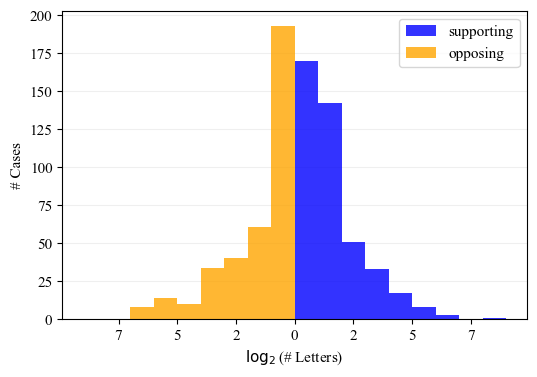

In [8]:
plt.figure(figsize=(6,4))
idx1 = df['n__support'] > 0
idx2 = df['n__oppose'] > 0
bins1 = np.arange(0, 10, 1)
bins2 = np.arange(-9, 1, 1)
plt.hist(np.log2(df.loc[idx1, 'n__support']), alpha=0.8, color='blue', label='supporting', bins=bins1)
plt.hist(-np.log2(df.loc[idx2, 'n__oppose']), alpha=0.8, color='orange', label='opposing', bins=bins2)
plt.xlabel(r'$\log_2$(# Letters)')
plt.ylabel('# Cases')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.gca().set_axisbelow(True)
def custom_formatter(xval, pos):
    if xval<0:
        return f"{abs(int(xval))}"
    else:
        return f"{int(xval)}"
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
#plt.title("Distribution of Support and Opposition Letters by Project")
plt.savefig(os.path.join(LOCAL_PATH, 'figures', 'fig_support_oppose.pdf'), bbox_inches='tight')
plt.show()

In [9]:
wt.update_results(RESULTS)

{'NumberOfMeetings': '153',
 'FirstMeetingDate': '2018-05-10',
 'LastMeetingDate': '2024-12-19',
 'NumberOfCases': '727',
 'PageCount': '23,633',
 'NumberOfYears': '7',
 'NumberOfAgendaItems': '1,497',
 'NumberOfSupplementalDocs': '6,447',
 'CasesDeniedPct': '1\\%',
 'CasesContinuedPct': '15\\%',
 'CasesApprovedWithModsPct': '30\\%',
 'CasesUnanimousPct': '91\\%'}